In [1]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import os

构造人工数据集

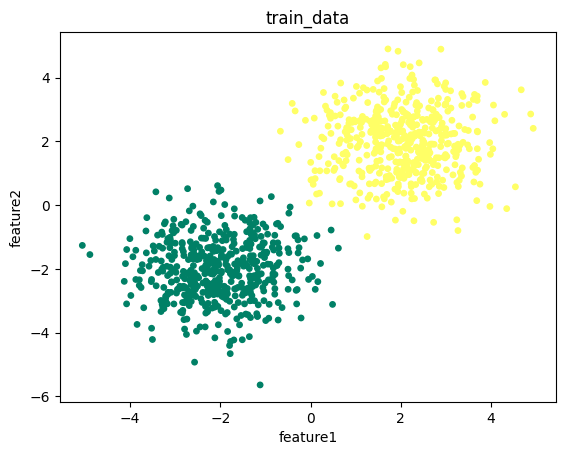

In [2]:
# 构造训练集
feat_num = 2
train_data_size = 500
n_data = torch.ones(train_data_size,feat_num)
x1 = torch.normal(2*n_data,1)
y1 = torch.ones(train_data_size)
x2 = torch.normal(-2*n_data,1)
y2 = torch.zeros(train_data_size)
train_feat = torch.cat((x1,x2),dim=0).type(torch.FloatTensor)
train_label = torch.cat((y1,y2),dim=0).type(torch.FloatTensor)
# 训练集可视化
plt.scatter(train_feat.data.numpy()[:,0], train_feat.data.numpy()[:,1], s=15, c=train_label.data.numpy(), marker='o', cmap='summer')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.title('train_data')
plt.show()

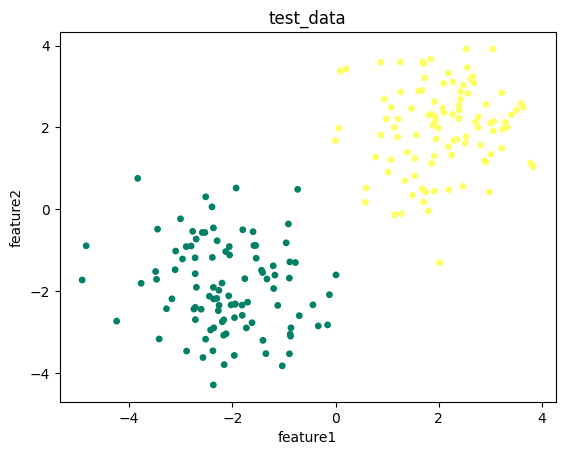

In [3]:
# 构造测试集
test_data_size = 100
n_data = torch.ones(test_data_size,feat_num)
x1 = torch.normal(2*n_data,1)
y1 = torch.ones(test_data_size)
x2 = torch.normal(-2*n_data,1)
y2 = torch.zeros(test_data_size)
test_feat = torch.cat((x1,x2),dim=0).type(torch.FloatTensor)
test_label = torch.cat((y1,y2),dim=0).type(torch.FloatTensor)
# 测试集可视化
plt.scatter(test_feat.data.numpy()[:,0], test_feat.data.numpy()[:,1], s=15, c=test_label.data.numpy(), marker='o', cmap='summer')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.title('test_data')
plt.show()

创建批量数据生成器

In [ ]:
import math
def create_batch_data(batch_size,x,y):
    ind = list(range(len(x)))
    random.shuffle(ind)
    count = int(math.ceil(len(ind)/batch_size))
    for i in range(count):
        data_index = torch.LongTensor(ind[i*batch_size:(i+1)*batch_size])
        yield torch.index_select(x,0,data_index), torch.index_select(y,0,data_index)

初始化模型参数

In [5]:
w = torch.normal(mean = 0, std = 0.01, size=(feat_num,1), dtype=torch.float32, requires_grad=True)
b = torch.ones(1,dtype=torch.float32,requires_grad=True)

实现logistic回归算法

In [6]:
def logistic(x,w,b):
    y = torch.mm(x,w)+b
    return 1/(1+torch.pow(np.e,-y))

实现BCE_loss计算

In [7]:
def loss_func(pred_y,true_y):
    true_y = true_y.view(pred_y.shape)
    loss = 0
    length = len(pred_y)
    for i in range(length):
        if true_y[i] == 1:
            loss += -true_y[i] * torch.log(pred_y[i])
        elif true_y[i] == 0:
            loss += -(1-true_y[i]) * torch.log(1-pred_y[i])
    return loss/length

定义小批量随机梯度下降算法

In [8]:
def batch_sgd(params,batch_size,lr):
    for par in params:
        par.data -= lr*par.grad/batch_size

定义测试集的评价指标计算

In [9]:
def evaluate_test(w,b,batch_size):
    test_loss_sum = 0
    test_acc_sum = 0
    test_length = 0
    for test_x,test_y in create_batch_data(batch_size,test_feat,test_label):
        pred = logistic(test_x,w,b)
        pred_y = torch.squeeze(torch.where(pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        loss = loss_func(pred_y,test_y)
        test_loss_sum += loss.item()
        test_acc_sum += (pred_y==test_y).sum().item()
        test_length += test_y.shape[0]
    return test_acc_sum/test_length,test_loss_sum/test_length

搭建模型训练验证过程

In [10]:
# 初始化模型训练参数
lr = 0.03 # 学习率
epoch = 100 
batch_size = 10
train_loss, test_loss = [], []
train_acc, test_acc = [], []
# 模型训练测试
for e in range(epoch):
    train_loss_sum = 0
    train_acc_sum = 0
    train_length = 0
    for train_x,train_y in create_batch_data(batch_size,train_feat,train_label):
        pred = logistic(train_x,w,b)
        los = loss_func(pred,train_y)
        los.backward() # 计算梯度
        batch_sgd([w,b],batch_size,lr) # 梯度更新
        w.grad.data.zero_() # 梯度清零
        b.grad.data.zero_()
        train_loss_sum += los.item() #item()用于取出张量里的元素值
        pred_y = torch.squeeze(torch.where(pred>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        train_acc_sum += (pred_y==train_y).sum().item()
        train_length += train_y.shape[0]
    train_epoch_loss = loss_func(logistic(train_feat,w,b),train_label).item()/train_length
    print('epoch %d, loss %f' % (e + 1, train_epoch_loss))
    ta,tl = evaluate_test(w,b,batch_size)
    test_acc.append(ta)
    test_loss.append(tl)
    train_acc.append(train_acc_sum/train_length)
    train_loss.append(train_loss_sum/train_length)
    print('epoch %d, train_loss %.3f, train_acc：%.3f, test_acc %.3f'% (e + 1, train_loss[e], train_acc[e], test_acc[e]))      

epoch 1, loss 0.000417
epoch 1, train_loss 0.058, train_acc：0.561, test_acc 0.725
epoch 2, loss 0.000269
epoch 2, train_loss 0.033, train_acc：0.890, test_acc 0.965
epoch 3, loss 0.000199
epoch 3, train_loss 0.023, train_acc：0.971, test_acc 0.975
epoch 4, loss 0.000159
epoch 4, train_loss 0.018, train_acc：0.980, test_acc 0.980
epoch 5, loss 0.000133
epoch 5, train_loss 0.015, train_acc：0.986, test_acc 0.985
epoch 6, loss 0.000115
epoch 6, train_loss 0.012, train_acc：0.989, test_acc 0.990
epoch 7, loss 0.000102
epoch 7, train_loss 0.011, train_acc：0.990, test_acc 0.990
epoch 8, loss 0.000092
epoch 8, train_loss 0.010, train_acc：0.990, test_acc 0.995
epoch 9, loss 0.000084
epoch 9, train_loss 0.009, train_acc：0.992, test_acc 0.995
epoch 10, loss 0.000078
epoch 10, train_loss 0.008, train_acc：0.994, test_acc 0.995
epoch 11, loss 0.000072
epoch 11, train_loss 0.007, train_acc：0.995, test_acc 0.995
epoch 12, loss 0.000068
epoch 12, train_loss 0.007, train_acc：0.996, test_acc 0.995
epoch 13, 

可视化模型的训练效果

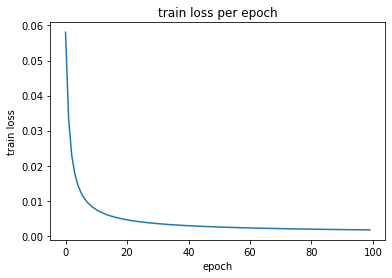

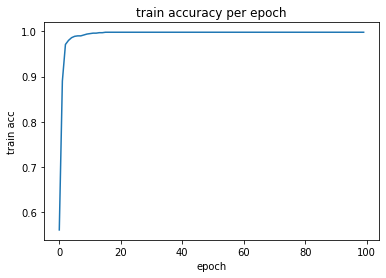

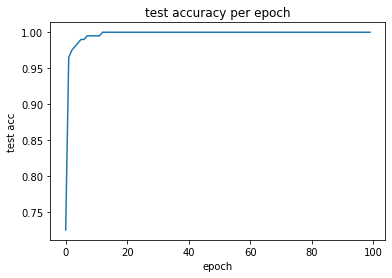

In [11]:
plt.plot(range(epoch), train_loss)
plt.xlabel('epoch')
plt.ylabel('train loss')
plt.title("train loss per epoch")
plt.show()
plt.plot(range(epoch), train_acc)
plt.xlabel('epoch')
plt.ylabel('train acc')
plt.title("train accuracy per epoch")
plt.show()
plt.plot(range(epoch), test_acc)
plt.xlabel('epoch')
plt.ylabel('test acc')
plt.title("test accuracy per epoch")
plt.show()

实验结果分析

随着迭代次数的增加，模型在训练集上的损失逐渐下降，在测试集上的准确率也逐渐升高。在第10次迭代时，模型在测试集上的准确率已近似1，说明该模型的拟合速度较快，之后的迭代也保持平稳。